# Введение в нейронные сети

## Урок 3. TensorFlow

### Практическое задание

В конце ноутбука создаются два массива с рукописными буквами и с характеристиками вина.

Задание на дом: выбрать датасет, возможно, предварительно обработать, создать модель нейронной сети, обучить и проверить точность на тестовом датасете. Напишите свои мысли по поводу результатов.

При желании можно рассмотреть оба датасета, можете попробовать применить другие методы машинного обучения, известные вам, и сравнить результаты обучения.

### Решение

Задание с разбором рукописных символов выглядит интереснее с технической точки зрения поэтому выберем его.

#### Импорт библиотек

In [62]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score

#### Глобальные настройки проекта

In [2]:
# Случайное зерно.
GLOBAL__RANDOM_STATE = 0

# Путь: веса обученной нейросети.
PATH__MODEL_WEIGHTS = r'weights'

#### Загрузка данных

In [3]:
# Классы целевой переменной.
classes = [str(i) for i in range(10)] +  list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

# Вычисление количества классов.
n_classes = len(classes)

# Проверка: вывод количества классов.
n_classes

36

In [4]:
# Загрузка признаков и целевой переменной.
X = np.load('binary_alpha_digits_images.npy')
y = np.load('binary_alpha_digits_labels.npy')

# Проверка: вывод размерности признаков и целевой переменной.
X.shape, y.shape

((1404, 20, 16), (1404,))

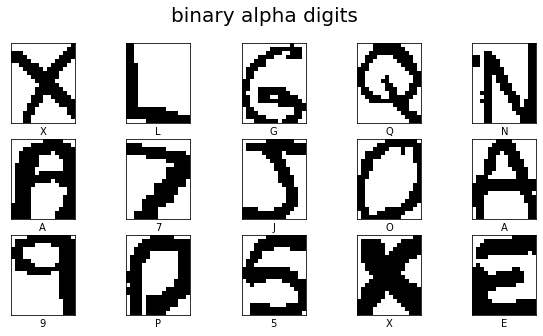

In [5]:
# Проверка: визуализация признаков.
fig, axes = plt.subplots(3, 5, figsize=(10, 5))
fig.suptitle('binary alpha digits', fontsize=20)
n = 0
for ax in axes.flat:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.imshow(X[n], cmap=plt.cm.binary)
    ax.set_xlabel(classes[y[n]])
    n += 1

#### Подготовка данных

In [6]:
# Вывод признаков первого объекта.
X[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 1, 1, 1, 0, 0,

Данные имеют бинарную кодировку поэтому их нормализация не требуется.

Представим каждый объект в виде одномерного вектора, чтобы также можно было обучить классические модели машинного обучения.

In [7]:
# Перевод признаков каждого объекта в ономерный вектор.
X = X.reshape(X.shape[0], -1)

# Проверка: вывод размерности признаков.
X.shape

(1404, 320)

In [8]:
# Вычисление количества признаков.
n_features = X.shape[1]

# Проверка: вывод количества признаков.
n_features

320

In [9]:
# Разбиение данных на обучающую и тестовую выборки.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=GLOBAL__RANDOM_STATE)

# Проверка: вывод размерностей выборок.
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1123, 320), (281, 320), (1123,), (281,))

#### Построение нейронной сети

In [47]:
# Инициализация модели и подбор гиперпараметров.
model = keras.Sequential([
#     keras.Input(320, batch_size=300),
    keras.Input(320),
    keras.layers.Dense(n_features,
                       activation='relu',
#                        activation='sigmoid',
#                        kernel_regularizer=tf.keras.regularizers.L2(l2=0.05),
#                        kernel_regularizer=tf.keras.regularizers.L2(l2=0.01),
                       bias_regularizer=tf.keras.regularizers.L2(l2=0.5)
                      ),
#     keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_features, activation='relu'),
    keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.1),
#     keras.layers.Dense(n_features, activation='relu'),
    keras.layers.Dense(n_features, activation='sigmoid'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_features, activation='relu'),
    keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.1),
#     keras.layers.Dense(n_features, activation='relu'),
    keras.layers.Dense(n_features, activation='sigmoid'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_features, activation='relu'),
    keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.1),
#     keras.layers.Dense(n_features, activation='relu'),
    keras.layers.Dense(n_features, activation='sigmoid'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_classes)
])

In [48]:
# Настройка переменного шага градиента.
boundaries = [2000, 4000]
values = [0.01, 0.005, 0.001]
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

# Настройка модели.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
# Вывод описания модели.
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 320)               102720    
                                                                 
 batch_normalization_28 (Bat  (None, 320)              1280      
 chNormalization)                                                
                                                                 
 dense_33 (Dense)            (None, 320)               102720    
                                                                 
 batch_normalization_29 (Bat  (None, 320)              1280      
 chNormalization)                                                
                                                                 
 dense_34 (Dense)            (None, 320)               102720    
                                                                 
 batch_normalization_30 (Bat  (None, 320)             

In [54]:
%%time

# Обучение модели.
# model.fit(X_train, y_train, epochs=100, verbose=0)

# Загрузка весов лучшей обученной модели.
model.load_weights(PATH__MODEL_WEIGHTS)

Wall time: 114 ms


In [55]:
# Оценка метрики "accuracy" на обучающей выборке.
model.evaluate(X_train, y_train)

36/36 [==============================] - 0s 1ms/step - loss: 0.0759 - accuracy: 0.9679


[0.07592789083719254, 0.967943012714386]

In [56]:
# Оценка метрики "accuracy" на тестовой выборке.
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 1.4219 - accuracy: 0.7473


[1.4218926429748535, 0.7473309636116028]

In [57]:
# Сохранение весов лучшей модели с метрикой "accuracy": 0.7473.
# model.save_weights(PATH__MODEL_WEIGHTS)

Перебор гиперпараметров нейросети позволил получить значение метрики <code>accuracy</code> 0.7473 на тестовой выборке.

Разность значений метрики качества на обучающей и тестовой выборках показывает наличие переобучения модели, однако регуляризация весов приводила только к снижению качества прогноза на обоих выборках.

Наиболее эффективным оказалось попеременное использование слоёв с функциями активации <code>relu</code> и <code>sigmoid</code>.

Также стоит отметить, что количество нейронов в слоях равное количеству признаков благотворно сказывается на качестве сети.

Попробуем обучить градиентный бустинг и сравнить результаты.

#### Градиентный бустинг

In [59]:
# Инициализация модели CatBoostClassifier со стандартными настройками.
cbc = CatBoostClassifier(random_seed=GLOBAL__RANDOM_STATE)

In [61]:
%%time

# Обучение модели.
cbc.fit(X_train, y_train, verbose=0)

Wall time: 1min 57s


In [63]:
# Оценка метрики "accuracy" на обучающей выборке.
accuracy_score(y_train, cbc.predict(X_train))

0.9768477292965272

In [64]:
# Оценка метрики "accuracy" на тестовой выборке.
accuracy_score(y_test, cbc.predict(X_test))

0.7686832740213523

Согласно метрике <code>accuracy</code>, градиентный бустинг справился с задачей лучше, чем нейронная сеть. Значения метрик 0.77 и 0.75 у бустинга и нейросети соответственно.

Однако также стоить заметить, что при сопоставимых показателях метрики качества нейронная сеть обучались быстрее в ~12 раз. Построение нейросети заняло ~10 секунд, градиентного бустинга - ~2 минуты.